In [1]:
from datetime import date, timedelta, datetime
import polars as pl
import xarray as xr
import rioxarray
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
from rasterio.crs import CRS
from tqdm import tqdm

import matplotlib.pyplot as plt

from nrt.monitor.iqr import IQR

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Select sample
# we want a windthrow sample
exclude_disturbance_types = ~pl.col.label.is_in([
    213, 
    232,
    244,
    245
]).over("sample_id")
labels = pl.read_parquet("/home/jonas/.cache/disfor/0.1.0/labels.parquet").sort("sample_id", "start").filter(
        #((pl.col.start < monitor_start) & (pl.col.label >= 200)).over("sample_id"), # TODO: Discard entire sample, if condition is met
        exclude_disturbance_types
    )

In [4]:
samples = pl.read_parquet(
    "/home/jonas/.cache/disfor/0.1.0/samples.parquet", 
    use_pyarrow=True, 
    columns=["sample_id", "dataset", "cluster_id"]
)

In [5]:
wt = samples.filter(dataset=3)

In [12]:
for row in tqdm(wt.iter_rows(named=True), total=len(wt)):
    # start monitoring half a year before wt event
    monitoring_start = datetime.strptime(row["cluster_id"][2:], "%Y%m%d") - timedelta(days=365//2)
    disturbance_map(row["sample_id"], monitoring_start)

  0%|          | 0/294 [00:00<?, ?it/s]

100%|██████████| 294/294 [59:37<00:00, 12.17s/it] 


In [198]:
sample_id

3551

In [189]:
samples.filter(sample_id=3551)

dataset,sample_id,cluster_id
u8,u16,str
3,3551,"""PL20170817"""


In [154]:
sample_row = labels.filter(label=243).unique("sample_id").sample(1)
sample_id = sample_row["sample_id"][0]
monitor_start = date(sample_row["start"].dt.year()[0], 1,1)
sample_row

original_sample_id,dataset,label,original_label,start,end,sample_id,start_next_label
i64,u8,u16,str,"datetime[ms, UTC]","datetime[ms, UTC]",u16,"datetime[ms, UTC]"
490,3,243,"""7""",2017-09-30 00:00:00 UTC,2017-09-30 23:59:59 UTC,3551,2018-04-28 00:00:00 UTC


In [6]:
def tiffs_to_xarray(sample_id):
    # Directory containing your GeoTIFFs
    data_dir = Path(f"/home/jonas/.cache/disfor/0.1.0/tiffs/{sample_id}")

    # Get all .tif files and sort them
    tif_files = sorted(data_dir.glob("*.tif"))

    # Extract dates from filenames
    dates = pd.to_datetime([f.stem for f in tif_files])

    # Band names in order
    band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "SCL"]

    # Load all GeoTIFFs into a list of DataArrays
    data_arrays = []
    for tif_file in tif_files:
        da = rioxarray.open_rasterio(tif_file, masked=True)
        # Assign band names to the band dimension
        da = da.assign_coords(band=band_names)
        data_arrays.append(da)

    # Concatenate along a new time dimension
    da = xr.concat(data_arrays, dim='time')

    # Assign the time coordinates
    da = da.assign_coords(time=dates)

    # Convert to Dataset with each band as a variable
    ds = da.to_dataset(dim='band')

    # Apply the transformation
    transformed = (
        0.0315 * ds.B02 + 
        0.2021 * ds.B03 + 
        0.3102 * ds.B04 + 
        0.1594 * ds.B08 - 
        0.6806 * ds.B11 - 
        0.6109 * ds.B12
    )
    ndmi = ((ds["B08"] - ds["B11"]) / (ds["B08"] + ds["B11"]))

    # Apply the SCL mask (keep only pixels with SCL values 4, 5, 6, or 7)
    transformed = transformed.where(ds.SCL.isin([4, 5, 6, 7]))
    ndmi = ndmi.where(ds.SCL.isin([4, 5, 6, 7]))

    # Add the transformed data as a new variable to the dataset
    ds['tcw'] = transformed
    ds["ndmi"] = ndmi

    return ds

In [7]:
def disturbance_map(sample_id, monitor_start):
    ds = tiffs_to_xarray(sample_id)
    value_band = "tcw"
    history = ds[value_band].sel(time=slice(None, monitor_start))
    monitor = ds[value_band].sel(time=slice(monitor_start, None))
    # exclude any that have too few values
    mask = (np.count_nonzero(~history.isnull(), axis=0) > 10)

    params = {
        'sensitivity': (8.863739342930032, 1.947132456851802),
        'trend': False,
        'harmonic_order': 1,
        'boundary': 6,
        'L': 5.822364321398805
    }
    nrt_class = IQR(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        boundary=params['boundary']
    )
    nrt_class.fit(method="OLS", dataarray=history, screen_outliers='Shewhart', L=params['L'])
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date, update_mask=True)

    first_detection_only = nrt_class.first_detection * (nrt_class.mask == 3)
    meta = {
        'driver': "COG",
        'crs': ds.rio.crs.to_epsg(),
        'count': 1,
        'dtype': first_detection_only.dtype,
        'transform': nrt_class.transform,
        'height': first_detection_only.shape[-2],
        'width': first_detection_only.shape[-1],
        'nodata': 0
    }
    with rasterio.open(f"detections/{sample_id}.tif", 'w', **meta) as dst:
        dst.write(first_detection_only[np.newaxis, :])

In [ ]:
# first make maps for all of those windthrow events
# in these cases: Take the event date from the samples cluster column, and use that as cutoff?

In [188]:
date(1970,1,1) + timedelta(days=17392)

datetime.date(2017, 8, 14)

In [157]:
# Directory containing your GeoTIFFs
data_dir = Path(f"/home/jonas/.cache/disfor/0.1.0/tiffs/{sample_id}")

# Get all .tif files and sort them
tif_files = sorted(data_dir.glob("*.tif"))

# Extract dates from filenames
dates = pd.to_datetime([f.stem for f in tif_files])

# Band names in order
band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "SCL"]

# Load all GeoTIFFs into a list of DataArrays
data_arrays = []
for tif_file in tif_files:
    da = rioxarray.open_rasterio(tif_file, masked=True)
    # Assign band names to the band dimension
    da = da.assign_coords(band=band_names)
    data_arrays.append(da)

# Concatenate along a new time dimension
da = xr.concat(data_arrays, dim='time')

# Assign the time coordinates
da = da.assign_coords(time=dates)

# Convert to Dataset with each band as a variable
ds = da.to_dataset(dim='band')

print("Original dataset:")
print(ds)

# Apply the transformation
transformed = (
    0.0315 * ds.B02 + 
    0.2021 * ds.B03 + 
    0.3102 * ds.B04 + 
    0.1594 * ds.B08 - 
    0.6806 * ds.B11 - 
    0.6109 * ds.B12
)
ndmi = ((ds["B08"] - ds["B11"]) / (ds["B08"] + ds["B11"]))

# Apply the SCL mask (keep only pixels with SCL values 4, 5, 6, or 7)
transformed = transformed.where(ds.SCL.isin([4, 5, 6, 7]))
ndmi = ndmi.where(ds.SCL.isin([4, 5, 6, 7]))

# Add the transformed data as a new variable to the dataset
ds['tcw'] = transformed
ds["ndmi"] = ndmi

print("\nDataset with transformed variable:")
print(ds)

Original dataset:
<xarray.Dataset> Size: 29MB
Dimensions:      (time: 636, y: 32, x: 32)
Coordinates:
  * time         (time) datetime64[ns] 5kB 2015-07-11 2015-07-28 ... 2024-12-25
  * y            (y) float64 256B 5.834e+06 5.834e+06 ... 5.834e+06 5.834e+06
  * x            (x) float64 256B 6.783e+05 6.783e+05 ... 6.786e+05 6.786e+05
    spatial_ref  int64 8B 0
Data variables:
    B02          (time, y, x) float32 3MB 3.684e+03 4.048e+03 ... 244.0 277.0
    B03          (time, y, x) float32 3MB 3.512e+03 3.772e+03 ... 225.0 205.0
    B04          (time, y, x) float32 3MB 3.328e+03 3.584e+03 ... 164.0 155.0
    B05          (time, y, x) float32 3MB 3.67e+03 4.012e+03 ... 365.0 383.0
    B06          (time, y, x) float32 3MB 4.302e+03 4.606e+03 ... 579.0 514.0
    B07          (time, y, x) float32 3MB 4.52e+03 4.806e+03 ... 713.0 623.0
    B08          (time, y, x) float32 3MB 4.76e+03 4.988e+03 ... 675.0 694.0
    B8A          (time, y, x) float32 3MB 4.593e+03 4.832e+03 ... 835.0 760

In [158]:
value_band = "ndmi"
monitor_start = date(sample_row["start"].dt.year()[0], 1,1)

In [160]:
history = ds[value_band].sel(time=slice(None, monitor_start))
monitor = ds[value_band].sel(time=slice(monitor_start, None))

In [161]:
# exclude any that have too few values
mask = (np.count_nonzero(~history.isnull(), axis=0) > 10)

In [162]:
params_tcw_single_sensitivity = {
    'trend': False,
 'harmonic_order': 2,
 'sensitivity': 1.749100093768187,
 'boundary': 8,
 'L': 4.738243945688669
}

params_tcw = {
    'sensitivity': (8.863739342930032, 1.947132456851802),
 'trend': False,
 'harmonic_order': 1,
 'boundary': 6,
 'L': 5.822364321398805
}

params_ndmi = {'sensitivity_upper': 8.16992462547153,
 'sensitivity_lower': 2.1504342678501813,
 'trend': False,
 'harmonic_order': 2,
 'boundary': 6,
 'L': 21.667165633906336}

params_ndmi["sensitivity"] = (params_ndmi["sensitivity_upper"], params_ndmi["sensitivity_lower"])

params = params_tcw

In [163]:
nrt_class = IQR(
    trend=params['trend'],
    harmonic_order=params['harmonic_order'],
    mask=mask,
    sensitivity=params['sensitivity'],
    boundary=params['boundary']
)
nrt_class.fit(method="OLS", dataarray=history, screen_outliers='Shewhart', L=params['L'])

In [164]:
for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
    nrt_class.monitor(array=array, date=_date, update_mask=True)

In [185]:
# remove not 
first_detection_only = nrt_class.first_detection * (nrt_class.mask == 3)

In [187]:
meta = {'driver': "COG",
        'crs': ds.rio.crs.to_epsg(),
        'count': 1,
        'dtype': first_detection_only.dtype,
        'transform': nrt_class.transform,
        'height': first_detection_only.shape[-2],
        'width': first_detection_only.shape[-1],
        "nodata": 0
    }
with rasterio.open("test2.tif", 'w', **meta) as dst:
    dst.write(first_detection_only[np.newaxis, :])

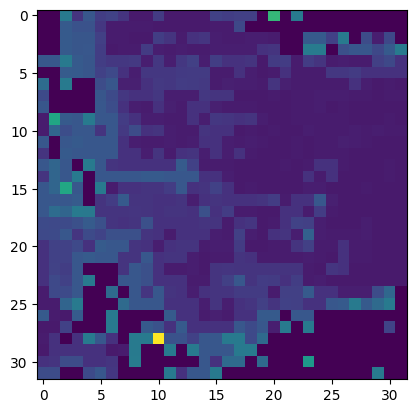

In [186]:
only_disturbed = first_detection_only[first_detection_only!=0]
plt.imshow(first_detection_only, vmin=only_disturbed.min()-200, vmax=only_disturbed.max())

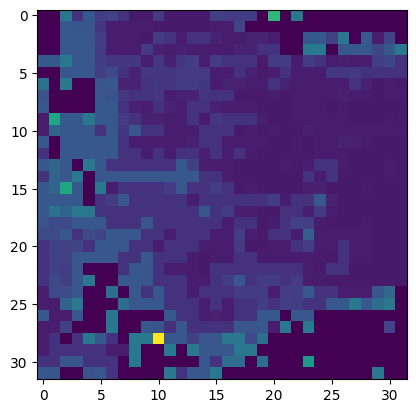

In [173]:
only_disturbed = nrt_class.detection_date[nrt_class.detection_date!=0]
plt.imshow(nrt_class.detection_date, vmin=only_disturbed.min()-200, vmax=only_disturbed.max())

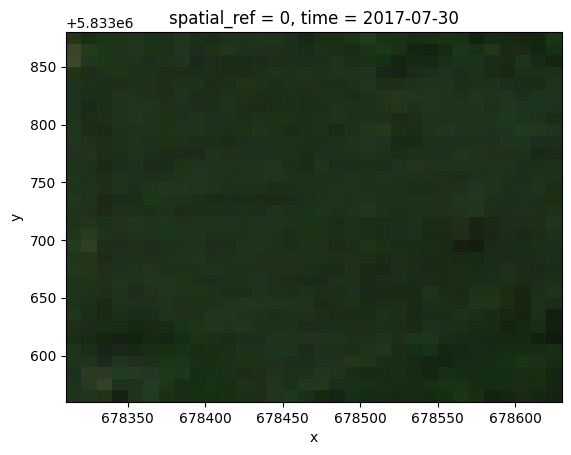

In [168]:
true_color = ds.sel(time="2017-07-26", method="nearest")[["B04", "B03", "B02"]].to_array() / 10000
# Divide by scale factor and apply gamma to brighten image
(true_color * 6).plot.imshow()

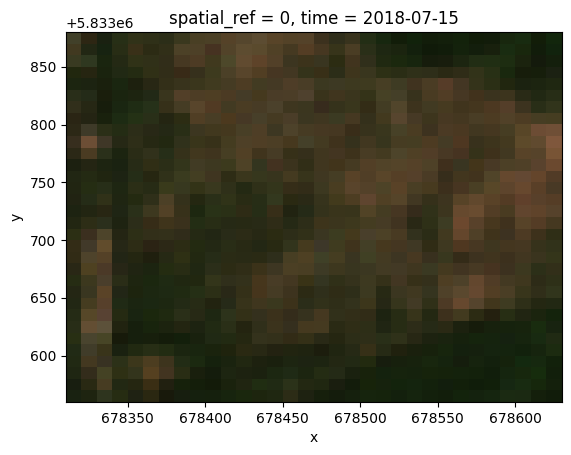

In [171]:
true_color = ds.sel(time="2018-07-15", method="nearest")[["B04", "B03", "B02"]].to_array() / 10000
# Divide by scale factor and apply gamma to brighten image
(true_color * 4).plot.imshow()

In [92]:
sample_row

original_sample_id,dataset,label,original_label,start,end,sample_id,start_next_label
i64,u8,u16,str,"datetime[ms, UTC]","datetime[ms, UTC]",u16,"datetime[ms, UTC]"
1117,1,243,"""7""",2018-02-14 00:00:00 UTC,2018-02-14 23:59:59 UTC,769,2019-03-21 00:00:00 UTC
